In [1]:
!rm -rf /content/samil-final
!git clone https://github.com/vineethagrl/samil-final.git /content/samil-final

%cd /content/samil-final
!pip install -q torch torchvision scikit-learn matplotlib pillow pandas tqdm


Cloning into '/content/samil-final'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 108 (delta 45), reused 3 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (108/108), 80.39 KiB | 1.22 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/samil-final


In [2]:
import torch, sys

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [3]:
import os, csv, random
from pathlib import Path

import numpy as np
from PIL import Image, ImageDraw

random.seed(7)
np.random.seed(7)

ROOT = Path("data/tmed2")
IMG_SIZE = 112
STUDIES = dict(train=60, val=20, test=20)
FRAMES_PER_STUDY = (24, 64)
CLASS_PRIORS = [0.60, 0.25, 0.15]
ATT_PCT_RELEVANT = 0.20
MAKE_ATT_TARGETS = True

def sample_label():
    r = random.random()
    if r < CLASS_PRIORS[0]:
        return 0
    elif r < CLASS_PRIORS[0] + CLASS_PRIORS[1]:
        return 1
    else:
        return 2

def echo_like_frame(size=IMG_SIZE, seed=None, signal=1.0):
    """Generate a fake echo-like grayscale image."""
    rs = np.random.RandomState(seed) if seed is not None else np.random

    img = Image.new("L", (size, size), color=0)
    draw = ImageDraw.Draw(img)
    cx, cy = size // 2 + rs.randint(-4, 4), size // 2 + rs.randint(-4, 4)
    for r in range(size // 6, size // 2, rs.randint(6, 10)):
        bb = [cx - r, cy - r, cx + r, cy + r]
        gray = int(min(255, rs.normal(loc=140 * signal, scale=30)))
        draw.arc(
            bb,
            start=rs.randint(0, 360),
            end=rs.randint(0, 360),
            fill=gray,
            width=rs.randint(1, 3),
        )

    arr = np.array(img, dtype=np.float32)
    noise = rs.normal(0, 18, arr.shape)
    arr = np.clip(arr + noise, 0, 255)
    mx, my = rs.randint(size // 4, 3 * size // 4), rs.randint(size // 4, 3 * size // 4)
    yy, xx = np.indices(arr.shape)
    dist = np.sqrt((xx - mx) ** 2 + (yy - my) ** 2)
    mask = np.clip(1.2 - (dist / (size * 0.9)), 0.7, 1.2)
    arr = np.clip(arr * mask, 0, 255)

    return Image.fromarray(arr.astype(np.uint8), mode="L")

def write_split(split, nstudies):
    split_dir = ROOT / split
    split_dir.mkdir(parents=True, exist_ok=True)

    labels_path = ROOT / f"{split}_labels.csv"
    att_path = ROOT / f"{split}_att.csv"

    with open(labels_path, "w", newline="") as lf:
        lw = csv.writer(lf)
        aw = None
        if MAKE_ATT_TARGETS:
            af = open(att_path, "w", newline="")
            aw = csv.writer(af)
        for i in range(nstudies):
            base_idx = dict(train=0, val=1000, test=2000)[split]
            sid = f"study_{base_idx + i:04d}"
            sdir = split_dir / sid
            sdir.mkdir(parents=True, exist_ok=True)

            label = sample_label()
            lw.writerow([sid, label])
            k = random.randint(*FRAMES_PER_STUDY)
            rel = set(random.sample(range(k), max(1, int(ATT_PCT_RELEVANT * k))))
            weights = np.zeros(k, dtype=np.float32)
            for t in range(k):
                signal = 1.3 if t in rel else 1.0
                img = echo_like_frame(
                    IMG_SIZE, seed=(hash(sid) + t) % (2**31), signal=signal
                )
                img.save(sdir / f"img_{t:04d}.png")
                weights[t] = 3.0 if t in rel else 1.0

            if MAKE_ATT_TARGETS:
                s = weights.sum() if weights.sum() > 0 else 1.0
                w = weights / s
                for t in range(k):
                    aw.writerow([sid, t, float(w[t])])

        if MAKE_ATT_TARGETS:
            af.close()
if ROOT.exists():
    import shutil
    shutil.rmtree(ROOT)

for split, n in STUDIES.items():
    write_split(split, n)

print("Done. Wrote dataset to:", ROOT)
!find data/tmed2 -maxdepth 2 -type d | head
!head -n 5 data/tmed2/train_labels.csv


/tmp/ipython-input-1783297486.py:54: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")


Done. Wrote dataset to: data/tmed2
data/tmed2
data/tmed2/test
data/tmed2/test/study_2013
data/tmed2/test/study_2004
data/tmed2/test/study_2018
data/tmed2/test/study_2002
data/tmed2/test/study_2017
data/tmed2/test/study_2010
data/tmed2/test/study_2011
data/tmed2/test/study_2008
study_0000,0
study_0001,0
study_0002,0
study_0003,0
study_0004,0


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import pandas as pd

class EchoStudyBags(Dataset):
    def __init__(self, root, split="train", img_size=112, use_att=False):
        self.root = Path(root)
        self.split = split
        self.img_size = img_size
        self.use_att = use_att

        labels_path = self.root / f"{split}_labels.csv"
        df = pd.read_csv(labels_path, header=None, names=["study_id", "label"])
        self.study_ids = df["study_id"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.att_map = {}
        att_path = self.root / f"{split}_att.csv"
        if use_att and att_path.exists():
            att_df = pd.read_csv(att_path, header=None, names=["study_id", "frame_idx", "target_weight"])
            for sid in self.study_ids:
                sub = att_df[att_df["study_id"] == sid]
                if len(sub) > 0:
                    self.att_map[sid] = torch.tensor(sub["target_weight"].values, dtype=torch.float32)

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.study_ids)

    def __getitem__(self, idx):
        sid = self.study_ids[idx]
        label = self.labels[idx]
        sdir = self.root / self.split / sid
        frames = sorted(list(sdir.glob("*.png")))
        imgs = []
        for fp in frames:
            img = Image.open(fp).convert("L")
            imgs.append(self.transform(img))
        bag = torch.stack(imgs, dim=0)
        att = self.att_map.get(sid, None)
        return bag, torch.tensor(label, dtype=torch.long), att

def collate_bags(batch):
    """
    batch: list of (bag, label, att_or_None)
    Returns:
        bags: list[Tensor] with variable-length T
        labels: Tensor (B,)
        atts: list[Optional[Tensor]]
    """
    bags = [b[0] for b in batch]
    labels = torch.stack([b[1] for b in batch])
    atts = [b[2] for b in batch]
    return bags, labels, atts
train_ds = EchoStudyBags("data/tmed2", split="train", img_size=112, use_att=True)
val_ds   = EchoStudyBags("data/tmed2", split="val",   img_size=112, use_att=True)
test_ds  = EchoStudyBags("data/tmed2", split="test",  img_size=112, use_att=True)

print("Train studies:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
bag0, y0, att0 = train_ds[0]
print("Example bag shape:", bag0.shape, "label:", y0.item(), "att target len:", None if att0 is None else len(att0))


Train studies: 60 Val: 20 Test: 20
Example bag shape: torch.Size([33, 1, 112, 112]) label: 0 att target len: 33


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class ABMIL(nn.Module):
    def __init__(self, feat_dim=128, hidden_dim=64, n_classes=3):
        super().__init__()
        self.feature_extractor = SmallCNN(out_dim=feat_dim)
        self.attention = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )
        self.classifier = nn.Linear(feat_dim, n_classes)

    def forward(self, bag):
        H = self.feature_extractor(bag)
        scores = self.attention(H).squeeze(-1)
        alpha = F.softmax(scores, dim=0)
        Z = torch.sum(alpha.unsqueeze(-1) * H, dim=0)
        logits = self.classifier(Z.unsqueeze(0))
        return {"logits": logits, "att": alpha, "rep": Z}

class SAMIL(nn.Module):
    def __init__(self, feat_dim=128, hidden_dim=64, n_classes=3, lambda_sa=0.5):
        super().__init__()
        self.feature_extractor = SmallCNN(out_dim=feat_dim)
        self.attention = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )
        self.classifier = nn.Linear(feat_dim, n_classes)
        self.lambda_sa = lambda_sa

    def forward(self, bag, att_target=None, label=None):
        """
        bag: (T,1,H,W)
        att_target: (T,) or None
        label: scalar LongTensor or None
        """

        H = self.feature_extractor(bag)

        scores = self.attention(H).squeeze(-1)
        alpha = F.softmax(scores, dim=0)

        Z = torch.sum(alpha.unsqueeze(-1) * H, dim=0)
        logits = self.classifier(Z.unsqueeze(0))

        out = {"logits": logits, "att": alpha, "rep": Z}
        if label is not None:
            ce = F.cross_entropy(logits, label.view(1))

            sa_loss = 0.0
            if att_target is not None:
                att_target = att_target.to(alpha.device)
                if att_target.numel() == alpha.numel():
                    eps = 1e-8
                    sa_loss = F.kl_div(
                        (alpha + eps).log(),
                        att_target + eps,
                        reduction="batchmean",
                    )

            out["ce"] = ce
            out["sa"] = sa_loss
            out["loss"] = ce + self.lambda_sa * sa_loss

        return out


In [6]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_epoch(model, loader, optimizer, is_samil=False):
    model.train()
    total_loss = 0.0
    n = 0
    for bags, labels, atts in tqdm(loader, leave=False):
        optimizer.zero_grad()
        loss_batch = 0.0
        for bag, y, att in zip(bags, labels, atts):
            bag = bag.to(device)
            y = y.to(device)
            att = att.to(device) if att is not None else None

            if is_samil:
                out = model(bag, att_target=att, label=y)
                loss = out["loss"]
            else:
                out = model(bag)
                logits = out["logits"]
                loss = F.cross_entropy(logits, y.view(1))

            loss_batch += loss

        loss_batch = loss_batch / len(bags)
        loss_batch.backward()
        optimizer.step()

        total_loss += loss_batch.item() * len(bags)
        n += len(bags)

    return total_loss / max(1, n)

def evaluate(model, loader, is_samil=False):
    model.eval()
    all_y = []
    all_logits = []
    with torch.inference_mode():
        for bags, labels, atts in loader:
            for bag, y, att in zip(bags, labels, atts):
                bag = bag.to(device)
                y = y.to(device)
                if is_samil:
                    out = model(bag, att_target=None, label=None)
                else:
                    out = model(bag)
                logits = out["logits"].squeeze(0)
                all_y.append(int(y.item()))
                all_logits.append(logits.cpu().numpy())
    import numpy as np
    all_y = np.array(all_y)
    all_logits = np.stack(all_logits, axis=0)
    preds = all_logits.argmax(axis=1)

    bal_acc = balanced_accuracy_score(all_y, preds)

    auroc_ovr = float("nan")
    if len(np.unique(all_y)) > 1:
        try:
            auroc_ovr = roc_auc_score(all_y, all_logits, multi_class="ovr")
        except ValueError:
            pass

    return bal_acc, auroc_ovr


Using device: cuda


In [7]:
BATCH_SIZE = 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_bags
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_bags
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_bags
)

len(train_loader), len(val_loader), len(test_loader)


(15, 5, 5)

In [8]:
import pandas as pd
import os

N_EPOCHS = 8

results = []

def run_experiment(name, model_ctor, is_samil=False):
    print(f"\n=== {name} ===")
    model = model_ctor().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val = -1.0
    best_state = None

    for epoch in range(N_EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, is_samil=is_samil)
        val_bal_acc, val_auroc = evaluate(model, val_loader, is_samil=is_samil)
        print(
            f"epoch {epoch}: val balanced-acc={val_bal_acc:.3f}, "
            f"auroc-ovr={val_auroc:.3f}, loss={train_loss:.3f}"
        )
        if val_bal_acc > best_val:
            best_val = val_bal_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    test_bal_acc, test_auroc = evaluate(model, test_loader, is_samil=is_samil)
    print(f"[TEST] {name}: balanced-acc={test_bal_acc:.3f}, auroc-ovr={test_auroc:.3f}")

    results.append(
        {
            "model": name,
            "val_balanced_acc": best_val,
            "test_balanced_acc": test_bal_acc,
            "test_auroc_ovr": test_auroc,
        }
    )

    return model


abmil_model = run_experiment(
    "ABMIL",
    lambda: ABMIL(feat_dim=128, hidden_dim=64, n_classes=3),
    is_samil=False,
)

samil_model = run_experiment(
    "SAMIL_lambda0.5",
    lambda: SAMIL(feat_dim=128, hidden_dim=64, n_classes=3, lambda_sa=0.5),
    is_samil=True,
)

samil_ablate_model = run_experiment(
    "SAMIL_lambda0.0",
    lambda: SAMIL(feat_dim=128, hidden_dim=64, n_classes=3, lambda_sa=0.0),
    is_samil=True,
)

results_df = pd.DataFrame(results)
os.makedirs("results", exist_ok=True)
results_path = "results/synthetic_tmed2_results.csv"
results_df.to_csv(results_path, index=False)
print(results_df)
print("Saved:", results_path)



=== ABMIL ===


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 0: val balanced-acc=0.500, auroc-ovr=nan, loss=1.073


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1: val balanced-acc=0.500, auroc-ovr=nan, loss=1.050


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2: val balanced-acc=0.500, auroc-ovr=nan, loss=1.023


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3: val balanced-acc=0.500, auroc-ovr=nan, loss=0.981


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4: val balanced-acc=0.500, auroc-ovr=nan, loss=0.941


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5: val balanced-acc=0.500, auroc-ovr=nan, loss=0.891


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 6: val balanced-acc=0.500, auroc-ovr=nan, loss=0.864


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 7: val balanced-acc=0.500, auroc-ovr=nan, loss=0.859
[TEST] ABMIL: balanced-acc=0.333, auroc-ovr=nan

=== SAMIL_lambda0.5 ===


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 0: val balanced-acc=0.500, auroc-ovr=nan, loss=1.052


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1: val balanced-acc=0.500, auroc-ovr=nan, loss=1.018


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2: val balanced-acc=0.500, auroc-ovr=nan, loss=0.975


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3: val balanced-acc=0.500, auroc-ovr=nan, loss=0.919


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4: val balanced-acc=0.500, auroc-ovr=nan, loss=0.875


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5: val balanced-acc=0.500, auroc-ovr=nan, loss=0.864


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 6: val balanced-acc=0.500, auroc-ovr=nan, loss=0.857


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 7: val balanced-acc=0.500, auroc-ovr=nan, loss=0.857
[TEST] SAMIL_lambda0.5: balanced-acc=0.333, auroc-ovr=nan

=== SAMIL_lambda0.0 ===


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 0: val balanced-acc=0.500, auroc-ovr=nan, loss=1.099


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1: val balanced-acc=0.500, auroc-ovr=nan, loss=1.063


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2: val balanced-acc=0.500, auroc-ovr=nan, loss=1.022


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3: val balanced-acc=0.500, auroc-ovr=nan, loss=0.977


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4: val balanced-acc=0.500, auroc-ovr=nan, loss=0.914


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5: val balanced-acc=0.500, auroc-ovr=nan, loss=0.883


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 6: val balanced-acc=0.500, auroc-ovr=nan, loss=0.859


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 7: val balanced-acc=0.500, auroc-ovr=nan, loss=0.858
[TEST] SAMIL_lambda0.0: balanced-acc=0.333, auroc-ovr=nan
             model  val_balanced_acc  test_balanced_acc  test_auroc_ovr
0            ABMIL               0.5           0.333333             NaN
1  SAMIL_lambda0.5               0.5           0.333333             NaN
2  SAMIL_lambda0.0               0.5           0.333333             NaN
Saved: results/synthetic_tmed2_results.csv


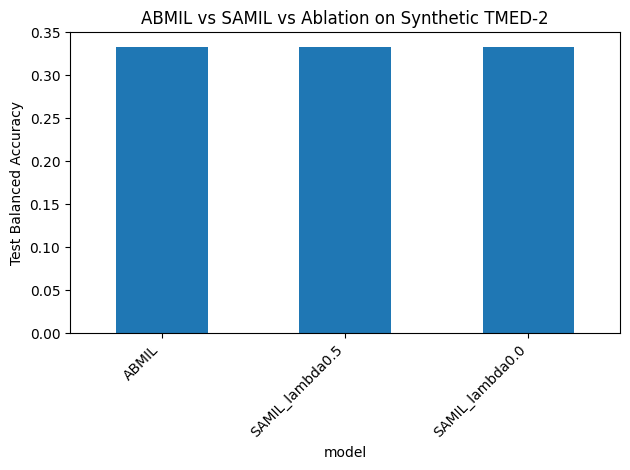

In [9]:
import matplotlib.pyplot as plt

ax = results_df.plot(x="model", y="test_balanced_acc", kind="bar", legend=False)
plt.ylabel("Test Balanced Accuracy")
plt.title("ABMIL vs SAMIL vs Ablation on Synthetic TMED-2")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
